# Все то же что в `analise_all_data.ipynb` но с привязкой к серии и номеру шага

In [1]:
import os
from functools import reduce

import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

from load_serie import load_all_series
from denoize import create_denoized_spline, build_box_plot
from shot_detector import new_detect_shots
from fragment_iterator import fragment_iterator
from shot_detector import States

from halpers import load_all_logs_in_folder, trimm_fragment_filter, \
        f_aprox

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
folder = 'data'

global_series = load_all_logs_in_folder(folder)

print(f'Всего {len(global_series)} серий')

Всего 235 серий


### Найдем все серии, где количество выстрелов больше 3-х

In [4]:
SMOOTH = 0.85
MIN_SHOTS = 3
MAX_TAIL_LEN = 30

In [13]:
series = []

for i, ts in enumerate(global_series):
    generator = iter(ts)
    fragments = [f for f in fragment_iterator(generator, SMOOTH, MAX_TAIL_LEN)]
    if len(fragments) >= MIN_SHOTS:
        shots = []
        for j, fragment_descr in enumerate(fragments):
            start = fragment_descr['start']
            points = fragment_descr['smooth_data']
            _min = min(points)
            _max = max(points)
            if len(points) <= 15 or \
                _max - _min > 1.0 or \
                _max - _min < 0.2 or \
                points[0] >= points[-1]:
                good = False
                continue
            fragment_descr['zero-aligned-smooth'] = np.array(points) - _min
            fragment_descr['zero-aligned-original'] = np.array(fragment_descr['y_origin']) - _min
            shots.append({'step': j, 'fragment': fragment_descr}) 
        
        if len(shots) >= MIN_SHOTS:
            print(f'Серия {i} содержит {len(shots)} выстрелов')
            series.append(shots)

print(f'Всего {len(series)} серий')

Серия 39 содержит 9 выстрелов
Серия 40 содержит 3 выстрелов
Серия 42 содержит 4 выстрелов
Серия 44 содержит 4 выстрелов
Серия 45 содержит 4 выстрелов
Серия 47 содержит 3 выстрелов
Серия 48 содержит 3 выстрелов
Серия 49 содержит 4 выстрелов
Серия 51 содержит 4 выстрелов
Серия 54 содержит 3 выстрелов
Серия 70 содержит 6 выстрелов
Серия 73 содержит 4 выстрелов
Серия 78 содержит 5 выстрелов
Серия 79 содержит 7 выстрелов
Серия 81 содержит 5 выстрелов
Серия 82 содержит 6 выстрелов
Серия 83 содержит 3 выстрелов
Серия 84 содержит 3 выстрелов
Серия 163 содержит 4 выстрелов
Серия 186 содержит 7 выстрелов
Серия 189 содержит 9 выстрелов
Серия 191 содержит 5 выстрелов
Серия 203 содержит 3 выстрелов
Серия 232 содержит 4 выстрелов
Серия 234 содержит 4 выстрелов
Всего 25 серий


In [14]:
trimmed_serries = []
for ts in series:
    shots = []
    for shot in ts:
        if trimm_fragment_filter(shot['fragment'], 0.5):
            shots.append(shot)
    if len(shots) > 1:
        trimmed_serries.append(ts)

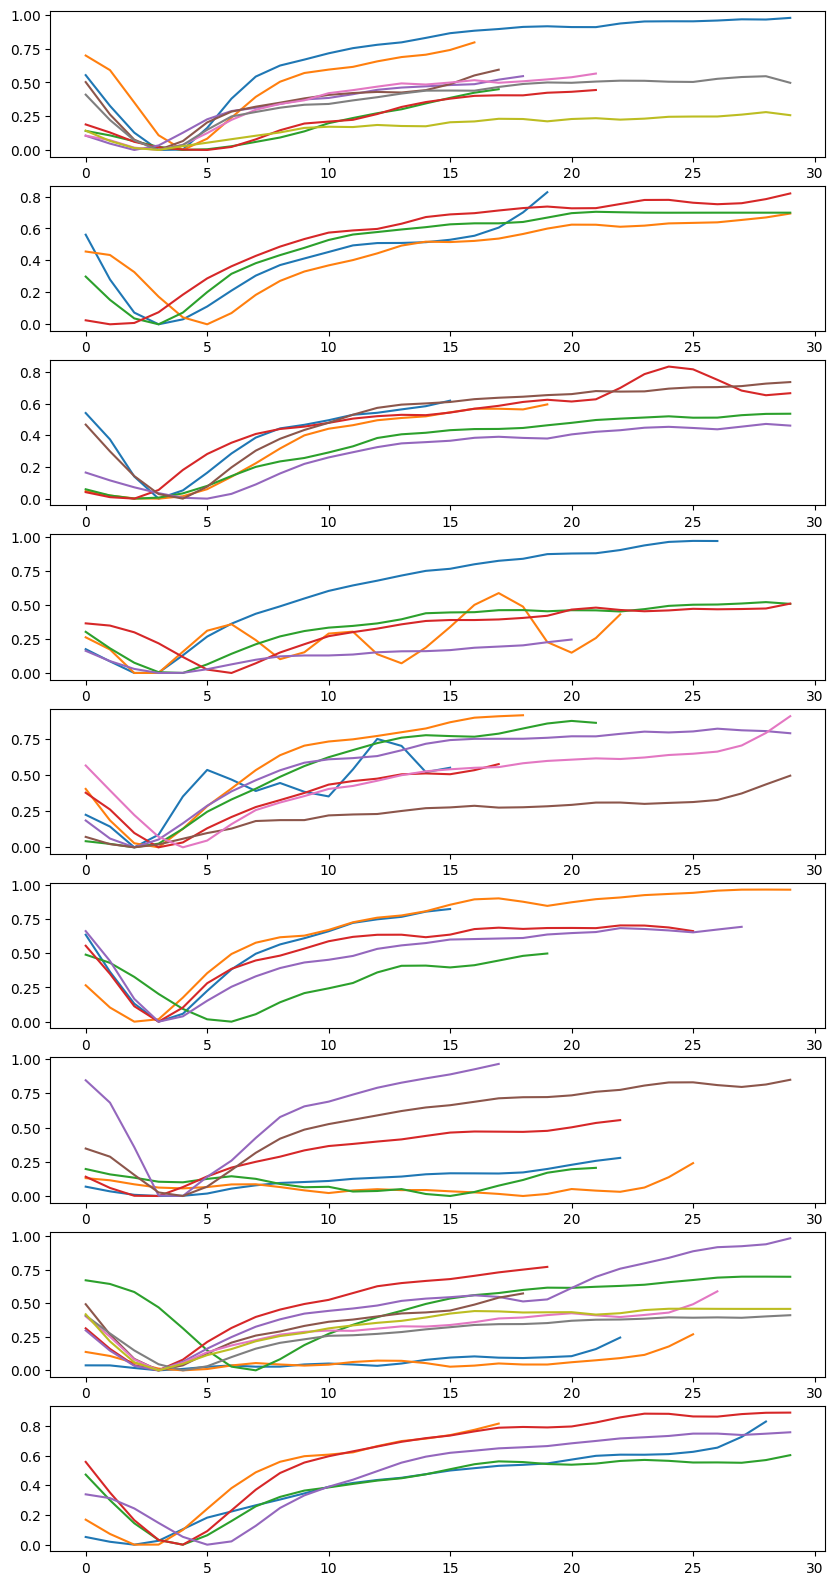

In [15]:
ts = trimmed_serries[0:]
_, ax = plt.subplots(len(ts), 1, figsize=(10, 20))
for i, ts in enumerate(ts):
    for shot in ts:
        fragment = shot['fragment']
        ax[i].plot(fragment['zero-aligned-smooth'])


Теперь разделим все графики на зону спада и подъёма, апроксимируем подём и посмотрм как высота подёма - высота спада коррелигует с номером шага для каждогй серии

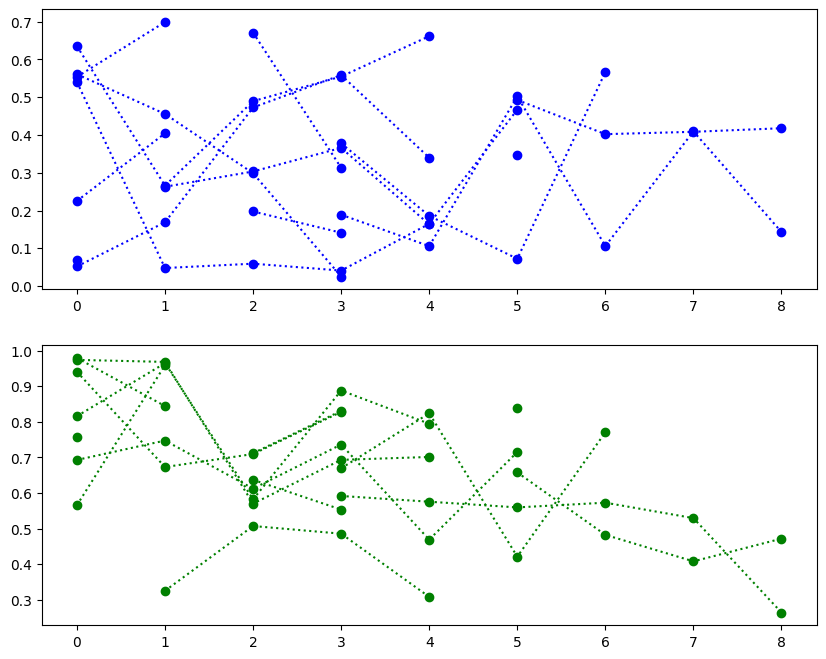

In [16]:
steps = []
for i, ts in enumerate(trimmed_serries):
    shots = np.zeros((len(ts), 3), dtype=np.float64)
    for j, shot in enumerate(ts):
        data = shot['fragment']['zero-aligned-smooth']
        min_index = np.argmin(data)

        # глубина провала
        deepness = data[0] - data[min_index]

        # апроксимация подёмной части
        x = np.linspace(0, len(data) - min_index - 1, len(data) - min_index)
        coeffs, _ = optimize.curve_fit(f_aprox, x, data[min_index:], p0=[1, 1], maxfev=10000)
        dest = coeffs[0]
        if dest < 1.0:
            shots[j] = (j, deepness, dest)
        else:
            shots[j] = (j, None, None)

    steps.append(shots)

#_, ax = plt.subplots(len(steps), 1, figsize=(10, 20))
#for i, s in enumerate(steps):
#    ax[i].plot(s[:, 0], s[:, 1], 'go:', label='deepness')
#    ax[i].plot(s[:, 0], s[:, 2], 'ro:', label='dest')

_, ax = plt.subplots(2, 1, figsize=(10, 8))
for s in steps:
    ax[0].plot(s[:, 0], s[:, 1], 'bo:', label='deepness')
    ax[1].plot(s[:, 0], s[:, 2], 'go:', label='dest')

Вывод:
- Глубина провала ни как не коррелирует с номером шага
- Высота подъёма коррелирует с номером шага но весьма слабо
Получается, что остается только:
1. Обнаруживать факт выстрела
2. Апроксимировать подъёмную часть
3. Вычитать висоту провала из ожидаемой высоты подъёма
4. Строить ящик с усами по этой серии и рисовать его сбоку от графика.

Попробуем сделать это на тех даных, что есть сейчас. С учетом всех ложных страбатываний.
___

## Прогнозирование
- `global_series` - изначальные данные. Для каздой из них:
    - Итерируемся по ним при помощи `fragment_iterator`
    - Фрагмент найден, пробуем разделить его на зону спада и подъёма
        - Вычисляем глубину спада
        - Апроксимуруем подъёмную часть, получаем высоту подъёма
        - Если апроксимация не удалась, значит фрагмент бракованый, отбрасываем его
        - Записываем результат в `serie_forecast`
        - Переходим к следующему фрагменту [...]
        - Если `serie_forecast` собержит хотя бы 3 фрагмента, то строим ящик с усами по ним
        - для следующего фрагмента рисуем этот ящик с усами

False

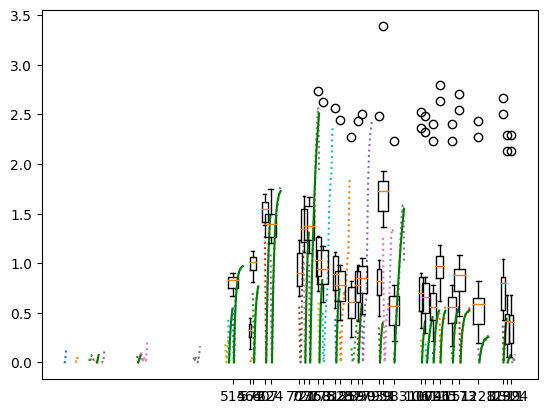

In [17]:
def build_forecast(serie) -> bool:
    generator = iter(serie)
    descrimed = False
    series_forecast = []
    for i, fragment_descr in enumerate(fragment_iterator(generator, SMOOTH, MAX_TAIL_LEN)):
        fragment_start = fragment_descr['start'] # номер точки в исходном ряду
        fragment_smooth_points = fragment_descr['smooth_data']  # значения сглаженного сигнала

        # Приводим к нулю
        min_index = np.argmin(fragment_smooth_points) # индекс точки с минимальным значением
        fragment_zero_aligned_smooth = np.array(fragment_smooth_points) - min(fragment_smooth_points) + 1e-3
        down_cut = fragment_zero_aligned_smooth[:min_index+1]
        up_cut = fragment_zero_aligned_smooth[min_index:]

        diff = fragment_zero_aligned_smooth[-1] - fragment_zero_aligned_smooth[0] 
        if diff < 0.01 or diff > 5:
            continue  # бракуем фрагменты где начало выше конца

        x = np.linspace(fragment_start, len(fragment_zero_aligned_smooth) - 1 + fragment_start, len(fragment_zero_aligned_smooth))
        plt.plot(x, fragment_zero_aligned_smooth, ':')

        if len(series_forecast) >= 3:
            forecast_data = list(map(lambda p: p['diff'], series_forecast))
            moved_data = np.array(forecast_data) + fragment_zero_aligned_smooth[0]
            plt.boxplot(moved_data, positions=[fragment_start], widths=[len(fragment_smooth_points)])

        # Глубина провала
        deepness = down_cut[0] - down_cut[-1]

        # Апроксимация подёмной части
        x = np.linspace(0, len(up_cut) - 1, len(up_cut))
        try:
            coeffs, _ = optimize.curve_fit(f_aprox, x, up_cut, p0=[1, 1])
            dest_forecast = coeffs[0]
        except RuntimeError:
            dest_forecast = 0.0

        if dest_forecast < 0.1 or dest_forecast > 5.0 or dest_forecast < deepness:
            continue  # бракуем фрагменты с неправильным прогнозом

        # plot forecast
        xf = np.linspace(fragment_start + min_index, fragment_start + len(up_cut) - 1 + min_index, len(up_cut))
        yf = [f_aprox(x, *coeffs) for x in x]
        plt.plot(xf, yf, 'g-')

        series_forecast.append({'N': i, 'start': fragment_start, 'diff': dest_forecast - deepness})

    return descrimed


SERIE_NUM = 39

build_forecast(global_series[SERIE_NUM])

Вывод: ну такое. Может быть когда-нибудь.
___